# Autoencoder sandbox  
---  
This notebook shows how to autoencode a 30 Hz sine wave with a varying phase.  At the end, the denoising properties of the autoencoder are showcased.  



In [2]:
import numpy as np 
import matplotlib.pyplot as plt




from keras.models import Input, Model, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import petname

Using TensorFlow backend.
/home/trap/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [40]:
# generate training, test, and validation data
n = 4096
nt = 128
f = 3.0                  # frequency in Hz
t = np.linspace(0,1,nt)  # time stamps in s
x = np.zeros((n,nt))
phase = np.random.uniform(-np.pi, np.pi, size=n)
for i in range(n):
    x[i,:] = np.sin(2*np.pi*f*t + phase[i] )

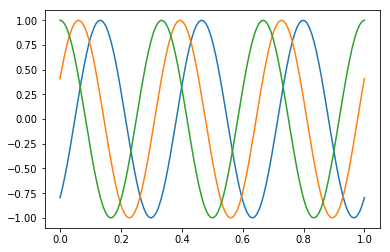

In [41]:
# QC generated data is phase shifted but one frequency
for i in range(3):
    plt.plot(t,x[np.random.randint(0,nt-1), :])
plt.show()

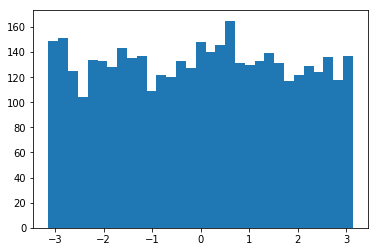

In [42]:
# QC generated phase in [-pi,pi]
plt.hist(phase,bins=31)
plt.show()

In [43]:
# split into training and test
x_temp, x_test, _, _ = train_test_split(x, x, test_size=0.05)
x_train, x_valid, _, _ = train_test_split(x_temp,
                                          x_temp,
                                          test_size=0.1)
n_train = len(x_train)
n_valid = len(x_valid)
n_test = len(x_test)

In [84]:
# construct network structure
activation = 'sigmoid'
encoding_dim = 11

# input layer is full time series length nt
inputs = Input((nt,))

# add more hidden layers here
d1 = Dense(encoding_dim, activation='tanh' )(inputs) 

# output layer is same length as input
outputs = Dense(nt, activation='tanh')(d1)

# consolidate to define autoencoder model inputs and outputs
ae = Model(inputs=[inputs], outputs=[outputs])

# specify encoder and decoder model for easy encoding and decoding
encoder_input = Input(shape=(encoding_dim,))
encoder = Model(inputs=inputs, outputs=d1)
decoder_layer = ae.layers[-1]
decoder = Model(inputs=encoder_input, outputs=decoder_layer(encoder_input))

In [85]:
ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1419      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1536      
Total params: 2,955
Trainable params: 2,955
Non-trainable params: 0
_________________________________________________________________


In [86]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 11)                1419      
Total params: 1,419
Trainable params: 1,419
Non-trainable params: 0
_________________________________________________________________


In [87]:
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 11)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1536      
Total params: 1,536
Trainable params: 1,536
Non-trainable params: 0
_________________________________________________________________


In [88]:
# specify opt. strategy
ae.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['mae'])

In [89]:
# specify training params
batch_size = 16
epochs = 1000
unique_name = petname.name()
model_filename = 'aen_sin_%03dHz_n=%05d_'%(int(f),nt)+unique_name+'.h5'
history_filename = 'results_'+unique_name+'.npz'
earlystopper = EarlyStopping(patience=100, verbose=1)
checkpointer = ModelCheckpoint(model_filename, verbose=1, save_best_only=True)
callbacks = [earlystopper, checkpointer]

In [90]:
# train
results = ae.fit(x_train,x_train,
                  batch_size = batch_size, 
                  epochs = epochs,
                  validation_data = (x_valid,x_valid),
                  callbacks = callbacks)

Train on 3501 samples, validate on 390 samples
Epoch 1/1000
3501/3501 [==============================] - 1s 156us/step - loss: -2.9629 - mean_absolute_error: 0.4893 - val_loss: -4.2080 - val_mean_absolute_error: 0.3893

Epoch 00001: val_loss improved from inf to -4.20798, saving model to aen_sin_003Hz_n=00128_aphid.h5
Epoch 2/1000
3501/3501 [==============================] - 0s 112us/step - loss: -4.3748 - mean_absolute_error: 0.3499 - val_loss: -4.5340 - val_mean_absolute_error: 0.3110

Epoch 00002: val_loss improved from -4.20798 to -4.53398, saving model to aen_sin_003Hz_n=00128_aphid.h5
Epoch 3/1000
3501/3501 [==============================] - 0s 134us/step - loss: -4.6346 - mean_absolute_error: 0.2840 - val_loss: -4.7415 - val_mean_absolute_error: 0.2571

Epoch 00003: val_loss improved from -4.53398 to -4.74150, saving model to aen_sin_003Hz_n=00128_aphid.h5
Epoch 4/1000
3501/3501 [==============================] - 0s 131us/step - loss: -4.7652 - mean_absolute_error: 0.2426 - val_

3501/3501 [==============================] - 0s 109us/step - loss: -4.8982 - mean_absolute_error: 0.0721 - val_loss: -4.8978 - val_mean_absolute_error: 0.0739

Epoch 00032: val_loss did not improve from -4.90671
Epoch 33/1000
3501/3501 [==============================] - 0s 106us/step - loss: -4.9011 - mean_absolute_error: 0.0671 - val_loss: -4.9052 - val_mean_absolute_error: 0.0637

Epoch 00033: val_loss did not improve from -4.90671
Epoch 34/1000
3501/3501 [==============================] - 0s 110us/step - loss: -4.9053 - mean_absolute_error: 0.0614 - val_loss: -4.9071 - val_mean_absolute_error: 0.0600

Epoch 00034: val_loss improved from -4.90671 to -4.90709, saving model to aen_sin_003Hz_n=00128_aphid.h5
Epoch 35/1000
3501/3501 [==============================] - 0s 115us/step - loss: -4.9055 - mean_absolute_error: 0.0594 - val_loss: -4.9054 - val_mean_absolute_error: 0.0593

Epoch 00035: val_loss did not improve from -4.90709
Epoch 36/1000
3501/3501 [==============================] 

3501/3501 [==============================] - 0s 129us/step - loss: -4.9146 - mean_absolute_error: 0.0302 - val_loss: -4.9122 - val_mean_absolute_error: 0.0373

Epoch 00066: val_loss did not improve from -4.91721
Epoch 67/1000
3501/3501 [==============================] - 0s 136us/step - loss: -4.9104 - mean_absolute_error: 0.0340 - val_loss: -4.9134 - val_mean_absolute_error: 0.0309

Epoch 00067: val_loss did not improve from -4.91721
Epoch 68/1000
3501/3501 [==============================] - 0s 115us/step - loss: -4.9142 - mean_absolute_error: 0.0303 - val_loss: -4.9175 - val_mean_absolute_error: 0.0280

Epoch 00068: val_loss improved from -4.91721 to -4.91746, saving model to aen_sin_003Hz_n=00128_aphid.h5
Epoch 69/1000
3501/3501 [==============================] - 0s 138us/step - loss: -4.9158 - mean_absolute_error: 0.0277 - val_loss: -4.9175 - val_mean_absolute_error: 0.0266

Epoch 00069: val_loss improved from -4.91746 to -4.91752, saving model to aen_sin_003Hz_n=00128_aphid.h5
Epoc

3501/3501 [==============================] - 0s 118us/step - loss: -4.9067 - mean_absolute_error: 0.0437 - val_loss: -4.9082 - val_mean_absolute_error: 0.0444

Epoch 00102: val_loss did not improve from -4.91752
Epoch 103/1000
3501/3501 [==============================] - 0s 119us/step - loss: -4.9095 - mean_absolute_error: 0.0412 - val_loss: -4.9106 - val_mean_absolute_error: 0.0387

Epoch 00103: val_loss did not improve from -4.91752
Epoch 104/1000
3501/3501 [==============================] - 0s 112us/step - loss: -4.9117 - mean_absolute_error: 0.0372 - val_loss: -4.9124 - val_mean_absolute_error: 0.0386

Epoch 00104: val_loss did not improve from -4.91752
Epoch 105/1000
3501/3501 [==============================] - 0s 113us/step - loss: -4.9099 - mean_absolute_error: 0.0381 - val_loss: -4.9095 - val_mean_absolute_error: 0.0390

Epoch 00105: val_loss did not improve from -4.91752
Epoch 106/1000
3501/3501 [==============================] - 0s 123us/step - loss: -4.9082 - mean_absolute_e

3501/3501 [==============================] - 0s 128us/step - loss: -4.9089 - mean_absolute_error: 0.0359 - val_loss: -4.9122 - val_mean_absolute_error: 0.0338

Epoch 00138: val_loss did not improve from -4.91752
Epoch 139/1000
3501/3501 [==============================] - 0s 132us/step - loss: -4.9081 - mean_absolute_error: 0.0369 - val_loss: -4.9132 - val_mean_absolute_error: 0.0359

Epoch 00139: val_loss did not improve from -4.91752
Epoch 140/1000
3501/3501 [==============================] - 0s 121us/step - loss: -4.9107 - mean_absolute_error: 0.0340 - val_loss: -4.9135 - val_mean_absolute_error: 0.0326

Epoch 00140: val_loss did not improve from -4.91752
Epoch 141/1000
3501/3501 [==============================] - 0s 120us/step - loss: -4.9111 - mean_absolute_error: 0.0341 - val_loss: -4.9074 - val_mean_absolute_error: 0.0395

Epoch 00141: val_loss did not improve from -4.91752
Epoch 142/1000
3501/3501 [==============================] - 0s 121us/step - loss: -4.9086 - mean_absolute_e


Epoch 00173: val_loss did not improve from -4.91893
Epoch 174/1000
3501/3501 [==============================] - 0s 107us/step - loss: -4.8970 - mean_absolute_error: 0.0502 - val_loss: -4.9013 - val_mean_absolute_error: 0.0451

Epoch 00174: val_loss did not improve from -4.91893
Epoch 175/1000
3501/3501 [==============================] - 0s 112us/step - loss: -4.9059 - mean_absolute_error: 0.0399 - val_loss: -4.9055 - val_mean_absolute_error: 0.0392

Epoch 00175: val_loss did not improve from -4.91893
Epoch 176/1000
3501/3501 [==============================] - 0s 112us/step - loss: -4.9057 - mean_absolute_error: 0.0344 - val_loss: -4.9056 - val_mean_absolute_error: 0.0361

Epoch 00176: val_loss did not improve from -4.91893
Epoch 177/1000
3501/3501 [==============================] - 0s 112us/step - loss: -4.9086 - mean_absolute_error: 0.0314 - val_loss: -4.9115 - val_mean_absolute_error: 0.0282

Epoch 00177: val_loss did not improve from -4.91893
Epoch 178/1000
3501/3501 [=============

3501/3501 [==============================] - 0s 117us/step - loss: -4.9155 - mean_absolute_error: 0.0247 - val_loss: -4.9168 - val_mean_absolute_error: 0.0246

Epoch 00210: val_loss did not improve from -4.91893
Epoch 211/1000
3501/3501 [==============================] - 0s 117us/step - loss: -4.9135 - mean_absolute_error: 0.0275 - val_loss: -4.9128 - val_mean_absolute_error: 0.0291

Epoch 00211: val_loss did not improve from -4.91893
Epoch 212/1000
3501/3501 [==============================] - 0s 123us/step - loss: -4.9103 - mean_absolute_error: 0.0311 - val_loss: -4.9165 - val_mean_absolute_error: 0.0246

Epoch 00212: val_loss did not improve from -4.91893
Epoch 213/1000
3501/3501 [==============================] - 0s 121us/step - loss: -4.9048 - mean_absolute_error: 0.0422 - val_loss: -4.9124 - val_mean_absolute_error: 0.0358

Epoch 00213: val_loss did not improve from -4.91893
Epoch 214/1000
3501/3501 [==============================] - 0s 125us/step - loss: -4.9120 - mean_absolute_e

3501/3501 [==============================] - 0s 107us/step - loss: -4.9139 - mean_absolute_error: 0.0287 - val_loss: -4.9151 - val_mean_absolute_error: 0.0288

Epoch 00246: val_loss did not improve from -4.91893
Epoch 247/1000
3501/3501 [==============================] - 0s 105us/step - loss: -4.9101 - mean_absolute_error: 0.0334 - val_loss: -4.9121 - val_mean_absolute_error: 0.0323

Epoch 00247: val_loss did not improve from -4.91893
Epoch 248/1000
3501/3501 [==============================] - 0s 107us/step - loss: -4.9130 - mean_absolute_error: 0.0302 - val_loss: -4.9070 - val_mean_absolute_error: 0.0382

Epoch 00248: val_loss did not improve from -4.91893
Epoch 249/1000
3501/3501 [==============================] - 0s 109us/step - loss: -4.9074 - mean_absolute_error: 0.0370 - val_loss: -4.9081 - val_mean_absolute_error: 0.0401

Epoch 00249: val_loss did not improve from -4.91893
Epoch 250/1000
3501/3501 [==============================] - 0s 104us/step - loss: -4.9082 - mean_absolute_e

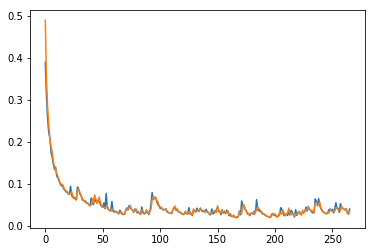

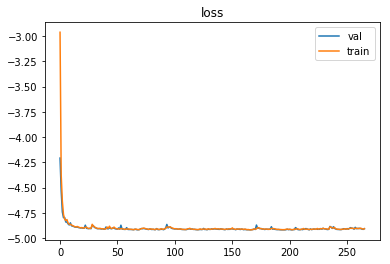

In [91]:
# QC training results
plt.plot(results.history['val_mean_absolute_error'], label='val')
plt.plot(results.history['mean_absolute_error'], label='train')
plt.show()

plt.plot(results.history['val_loss'], label='val')
plt.plot(results.history['loss'], label='train')
plt.title('loss')
plt.legend()
plt.show()

## QC encoding

In [104]:
encoded_sin = encoder.predict(x_test)
decoded_sin = decoder.predict(encoded_sin)

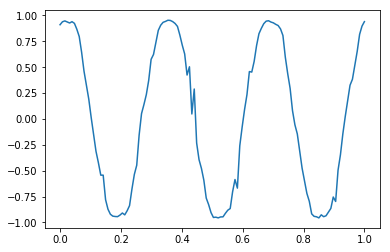

In [105]:
plt.plot(t,decoded_sin[np.random.randint(0,n_test-1),:])
plt.show()

# Showcase denoising properties of autoencoder  
---  

In [111]:
# specific sine wave index of interest
sin_index = np.random.randint(0,n_test-1)

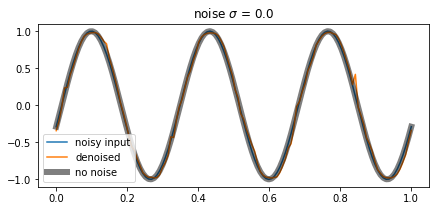

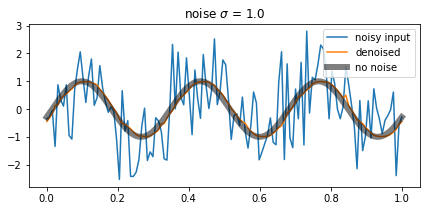

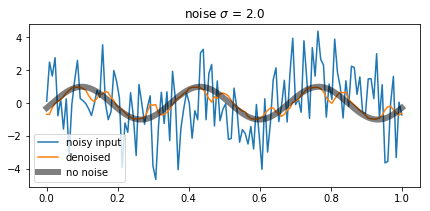

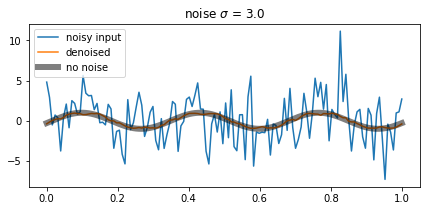

In [144]:
# effects of noise on input
for i in range(4):
    plt.figure(figsize=(7,3))
    sin_noisy = x_test + np.random.randn(n_test,nt)*i
    encoded_sin = encoder.predict(sin_noisy)
    decoded_sin = decoder.predict(encoded_sin)
    
    plt.plot(t, sin_noisy[sin_index,:], label='noisy input')
    plt.plot(t,decoded_sin[sin_index,:], label='denoised')
    plt.plot(t,x_test[sin_index,:], 'k', lw=6, alpha=0.5, label='no noise')
    plt.title('noise $\sigma$ = %2.1f'%i)
    plt.legend()
    plt.show()
